<h1> CM3070-Final Year Project-Semantic Segementation for self driving cars</h1>

<h3>Project Template: CM3015 Machine Learning and Neural Networks, Deep Learning on a Public Dataset</h3>

##### Importing required libraries
<p style='text-align: justify;'>In the step we will be importing required libraries and modules necessary for building various models and analysis of the chosen dataset. </p>

In [1]:
import numpy as np
import pandas as pd
import random
import os
import imageio
import cv2
import warnings
warnings.filterwarnings('ignore')

#visulization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#data augementation library
from imgaug import augmenters as iaa

#Tenserflow and keras
import tensorflow as tf 
from tensorflow import keras
import keras.backend as K
from keras.callbacks import Callback
from keras.regularizers import l1,l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Add, BatchNormalization, concatenate, Input, Dropout
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,ConvLSTM2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, BatchNormalization

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score

Images and its respective blank masks are imported from the dataset and initialising the filepath to all the directories present from the main directory.

In [2]:
#The dataset is acquired from the following:
#https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge

#initialising the filepath for images
sdcImage_path = ["selfDrivingCarsMask/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
#initialising the filepath for masks
sdcMask_path = ["selfDrivingCarsMask/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

A function named get_imgFilePath is initialised which iterates over each directory path where images are  stored and returns image paths inside each directory present.

In [3]:
#function to get images file_paths
def get_imgFilePath(filePaths):
    #initialising an empty array to store filepaths of images
    img_filePaths = []
    #iterating over length of file paths
    for file in range(len(filePaths)):
        #getting the list of all files
        img_files = os.listdir(filePaths[file])
        #iterating over images file paths and storing
        for img_file in img_files:
            img_filePaths.append(filePaths[file] + img_file)
    return img_filePaths

In [4]:
#implemeting get_imgFilePath on the images and masks
sdcImage_paths = get_imgFilePath(sdcImage_path)
sdcMask_paths = get_imgFilePath(sdcMask_path)

In [5]:
#Printing the number of images and masks present in the entire dataset
num_sdcImages=len(sdcImage_paths)
num_sdcMasks= len(sdcMask_paths)
print("Total number of images present in the Self-Driving Car dataset: ",num_sdcImages)
print("Total number of masks present in the Self-Driving Car dataset: ",num_sdcImages)

Total number of images present in the Self-Driving Car dataset:  5000
Total number of masks present in the Self-Driving Car dataset:  5000


##### Reading images to preview random unmasked and masked images.

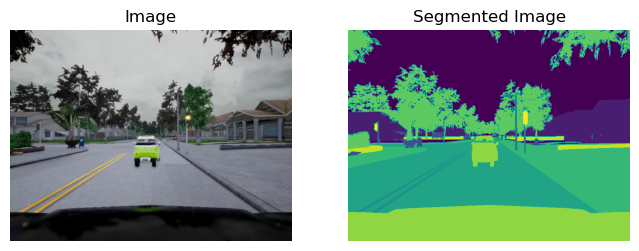

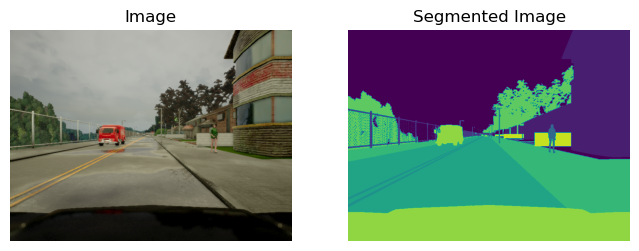

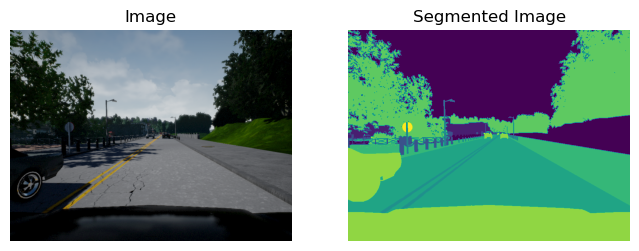

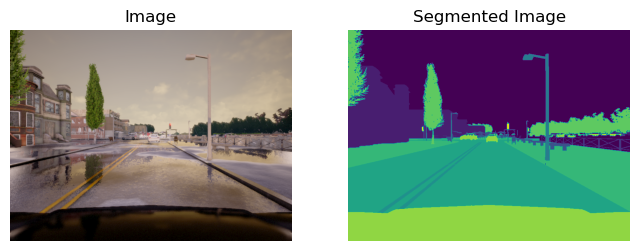

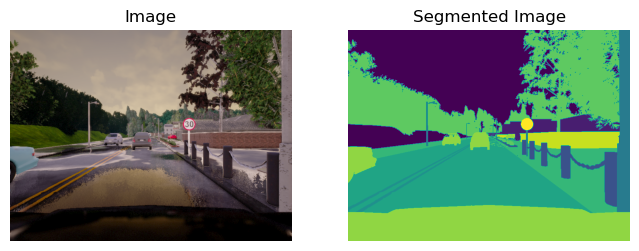

In [6]:
#plotting random image and its respective segmented image
num_ImgSamples=len(sdcImage_paths)

for k in range(5):
    preview=random.randint(0,num_ImgSamples-1)
    #using imageio to read the images
    img_preview=imageio.imread(sdcImage_paths[preview])
    mask_preview=imageio.imread(sdcMask_paths[preview])
    mask_preview=np.array([max(mask_preview[k, l]) for k in range(mask_preview.shape[0]) 
                           for l in range(mask_preview.shape[1])]).reshape(img_preview.shape[0], img_preview.shape[1])
    
    figImg, arr = plt.subplots(1, 2, figsize=(8, 8))
    arr[0].imshow(img_preview)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask_preview)
    arr[1].set_title('Segmented Image')
    arr[1].axis("off")

##### Data Augementation

A function named augumet_preprocess is initialised to preprocess images for data augmentation by the process of decoding the images into its 3 channels colors, converting into float type and resizing to the 256x256 pixels.

In [7]:
def augumet_preprocess(image_path,mask_path):
    #reading the image file
    img = tf.io.read_file(image_path)
    #decoding the images to ensure the output has 3 color channels
    img = tf.image.decode_png(img, channels=3)
    #converting into float type
    img = tf.image.convert_image_dtype(img, tf.float32)
    #resizing
    img = tf.image.resize(img, (256, 256), method='nearest')

    #reading the image file
    segmented_img = tf.io.read_file(mask_path)
    #decoding the images to ensure the output has 3 color channels
    segmented_img = tf.image.decode_png(segmented_img, channels=3)
    #reducing the number of color channels from 3 to 1
    segmented_img = tf.math.reduce_max(segmented_img, axis=-1, keepdims=True)
    #resizing
    segmented_img = tf.image.resize(segmented_img, (256, 256), method='nearest')
    
    return img,segmented_img

##### Cropping Images

Images are cropped to remove any possible interruptions from the surrounding area.

In [8]:
def crop_img(img):
    #initialising a random cropping scale
    crop_value= random.uniform(1, 1.3)
    #resizing
    cropped_img=tf.image.resize(img, (int(256/crop_value), int(256/crop_value)), method='nearest')
    #ensuring correct image-size
    cropped_img=tf.image.pad_to_bounding_box(cropped_img, 0, 0, 256, 256)
    return cropped_img

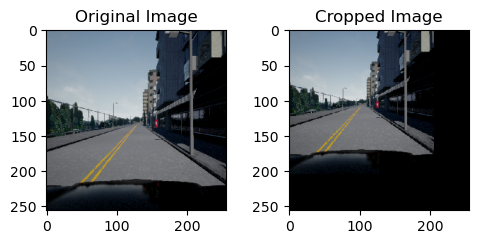

In [9]:
#plotting using crop_image-function
indexed_img = random.randint(0, len(sdcImage_paths)-1)
img_path = sdcImage_paths[indexed_img]
segImg_path = sdcMask_paths[indexed_img]

og_img, _ = augumet_preprocess(img_path,segImg_path)
cropped_img = crop_img(og_img)

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
fig.tight_layout()

axs[0].imshow(og_img)
axs[0].set_title('Original Image')

axs[1].imshow(cropped_img)
axs[1].set_title('Cropped Image')

plt.show()

#### Panning out the images

Images are panned to maintain consistent output dimenesions.

In [10]:
def img_panned(img):
    #initialising panning constant
    panning = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    #panning using the panning-varaiable
    img = panning.augment_image(img)
    #resizing
    img = tf.image.resize(img, (256, 256), method='nearest')
    return img

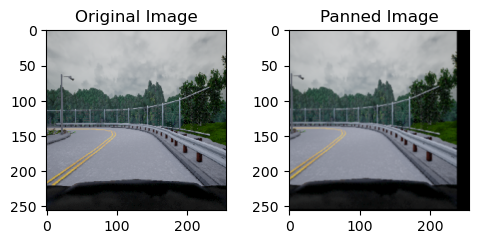

In [11]:
#plotting using img_panned-function
indexed_img = random.randint(0, len(sdcImage_paths)-1)
img_path = sdcImage_paths[indexed_img]
segImg_path = sdcMask_paths[indexed_img]

og_img, _ = augumet_preprocess(img_path,segImg_path)
og_img_np = og_img.numpy()
panned_img= img_panned(og_img_np)

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
fig.tight_layout()

axs[0].imshow(og_img_np)
axs[0].set_title('Original Image')

axs[1].imshow(panned_img)
axs[1].set_title('Panned Image')

plt.show()

#### Adjusting the brightness of the images

In [12]:
def adjust_brightness_img(img):
    #initialising brightness constant
    brightness_value = iaa.Multiply((0.2, 1.2))
    #changing the brightness using the brightness_value-Variable
    img = brightness_value.augment_image(img)
    #resizing
    img = tf.image.resize(img, (256, 256), method='nearest')
    return img

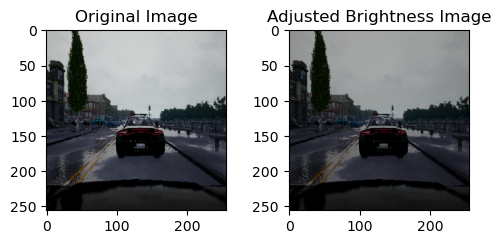

In [13]:
#plotting using adjust_brightness_img-function
indexed_img = random.randint(0, len(sdcImage_paths)-1)
img_path = sdcImage_paths[indexed_img]
segImg_path = sdcMask_paths[indexed_img]

og_img, _ = augumet_preprocess(img_path,segImg_path)
og_img_np = og_img.numpy()
adjusted_brightness_image = adjust_brightness_img(og_img_np)

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
fig.tight_layout()

axs[0].imshow(og_img_np)
axs[0].set_title('Original Image')

axs[1].imshow(adjusted_brightness_image)
axs[1].set_title('Adjusted Brightness Image')

plt.show()

#### Data augementation function
It consits of the combination of the functions above to modify the images in the dataset to be panned,cropped and brightness-adjusted.

In [14]:
def img_augmentation(img):
    #panning
    if np.random.rand() < 0.5:
        img = img_panned(img)
    #cropping
    if np.random.rand() < 0.5:
        img = crop_img(img)
    #brightess-adjustment
    if np.random.rand() < 0.5:
        img = adjust_brightness_img(img)
    #resizing
    img = tf.image.resize(img, (256, 256), method='nearest')
    return img

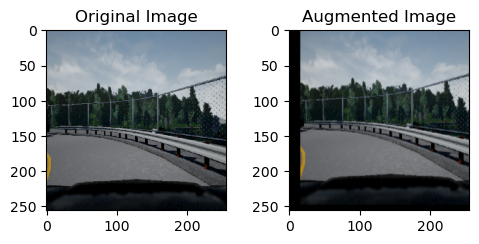

In [15]:
#plotting using img_augmentationfunction
indexed_img = random.randint(0, len(sdcImage_paths)-1)
img_path = sdcImage_paths[indexed_img]
segImg_path = sdcMask_paths[indexed_img]

og_img, _ = augumet_preprocess(img_path,segImg_path)
og_img_np = og_img.numpy()
augmented_img = img_augmentation(og_img_np)  

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
fig.tight_layout()

axs[0].imshow(og_img_np)
axs[0].set_title('Original Image')

axs[1].imshow(augmented_img)
axs[1].set_title('Augmented Image')

plt.show()

Results of data-augmented images are unsatisfactory, which can result in incorrect predictions. Therefore data-augmented images will not be trained by the model.

##### Pre-Processing of images into appropriate format for optimum results of the models.

In [16]:
#initialising file paths arrays for images and segemented images.
img_paths = []
segmentImg_paths = []

for img_fp in ['dataA','dataB', 'dataC', 'dataD', 'dataE']:
    img_pathDirectory = 'selfDrivingCarsMask/' + img_fp + '/' + img_fp + '/' + 'CameraRGB'
    segmentedImg_pathDirectory = 'selfDrivingCarsMask/' + img_fp+ '/' + img_fp + '/' + 'CameraSeg'

    for dirname, _, filenames in os.walk(img_pathDirectory):        
        for file_name in filenames:
            image_path = img_pathDirectory + '/' + file_name
            img_paths.append(image_path)
            segmentImage_path = segmentedImg_pathDirectory + '/' + file_name
            segmentImg_paths.append(segmentImage_path)

In [17]:
#function to read the file paths and resize images
def load_resize_img(fl_path,fil_path):
    img = cv2.imread(fl_path)
    img = tf.image.resize(img, (224, 224), method='nearest')
    
    segmentImg = np.array(cv2.imread(fil_path))
    segmentImg= np.array(cv2.resize(segmentImg, (224, 224), cv2.INTER_AREA))
    segmentImg = np.array([max(segmentImg[m, n]) for m in range(segmentImg.shape[0]) 
                           for n in range(segmentImg.shape[1])]).reshape(segmentImg.shape[0], segmentImg.shape[1])
    
    return np.array(img),segmentImg

In [18]:
#function to read the segmented images and identify the road as binary mask of 1
def segmentImg_road(segmentImg):
    segmentImg_road = np.zeros((224, 224, 1), dtype=np.int8)
    segmentImg_road[np.where(segmentImg==7)[0], np.where(segmentImg==7)[1]] = 1
    return np.array(segmentImg_road)

In [19]:
#function combining the before functions to preprocess the images
def preprocess_images(X_path, y_path):
    img_RGB,segmented_img = load_resize_img(X_path,y_path)
    road_segmented_img = segmentImg_road(segmented_img)
    return img_RGB, road_segmented_img

In [20]:
#function images_info-code is referenced from:https://www.kaggle.com/code/khatkeashish/semantic-segmentation-with-keras

def images_info(img_paths,segImg_paths):
    img = np.zeros((len(img_paths), 224, 224, 3), dtype=np.int16)
    road_segmented_img = np.zeros((len(img_paths), 224, 224, 1), dtype=np.int8)
    for img_index in range(len(img_paths)):
        X_path, y_path = img_paths[img_index], segImg_paths[img_index]
        img[img_index], road_segmented_img[img_index] = preprocess_images(X_path, y_path)
    return img, road_segmented_img

In [21]:
#loading all the images and its information
X_imgs, y_labels = images_info(img_paths,segmentImg_paths)

In [22]:
#spliting the data using train_test_splitfunction 
X_trainVal, X_testVal, y_trainVal, y_testVal = train_test_split(X_imgs, y_labels, 
                                                                test_size=0.2, shuffle =True,random_state=42)
X_trainVal, X_validVal, y_trainVal, y_validVal = train_test_split(X_trainVal, y_trainVal, 
                                                                  test_size=0.175, shuffle =True,random_state=42)

#printing the number of images in each set
print('Number of Semantic_seg_Train_images:',len(X_trainVal))
print('Number of Semantic_seg_Test_Images:',len(X_testVal))
print('Number of Semantic_seg_Validate_Images:',len(X_validVal))

Number of Semantic_seg_Train_images: 3300
Number of Semantic_seg_Test_Images: 1000
Number of Semantic_seg_Validate_Images: 700


In [23]:
#calculating the range of labels in training set
unique, count_value = np.unique(y_trainVal, return_counts=True)
print("Training labels: {}".format(dict(zip(unique, count_value))))

#calculating the range of labels in testing set
unique, count_value = np.unique(y_testVal, return_counts=True)
print("Testing labels: {}".format(dict(zip(unique, count_value))))

#calculating the range of labels in validation set
unique, count_value = np.unique(y_validVal, return_counts=True)
print("Validation labels: {}".format(dict(zip(unique, count_value))))

Training labels: {0: 132876769, 1: 32704031}
Testing labels: {0: 40297006, 1: 9878994}
Validation labels: {0: 28184959, 1: 6938241}


In [24]:
#printing shapes of values
print('Shape of Train_images:',X_trainVal.shape)
print('Shape of Train_Label:',y_trainVal.shape)
print('Shape of Test_Images:',X_testVal.shape)
print('Shape of Test_Label:',y_testVal.shape)
print('Shape of Validate_Images:',X_validVal.shape)
print('Shape of Validate_Label:',y_validVal.shape)

Shape of Train_images: (3300, 224, 224, 3)
Shape of Train_Label: (3300, 224, 224, 1)
Shape of Test_Images: (1000, 224, 224, 3)
Shape of Test_Label: (1000, 224, 224, 1)
Shape of Validate_Images: (700, 224, 224, 3)
Shape of Validate_Label: (700, 224, 224, 1)


###### Functions to summarize results for models

In [25]:
#function to tabluate results of model
def tabluate_result(history):
    return pd.DataFrame(history.history)

In [26]:
#function to tabluate mean-results of model
def training_mean_results(history):
    return pd.DataFrame(tabluate_result(history).mean(), columns=['Value']).style.set_caption('Training Mean')

#### Baseline model

In [27]:
input_shape = (224, 224, 3)
num_classes = 2

# encoder-architecture
inputs = Input(shape=input_shape)
x_layer = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
x_layer = MaxPooling2D((2, 2), padding='same')(x_layer)
encoded = x_layer

# decoder-architecture
x_layer = UpSampling2D((2, 2))(encoded)
x_layer = Conv2D(8, (3, 3), activation='relu', padding='same')(x_layer)
decoded = Conv2D(num_classes, (3, 3), padding='same')(x_layer)
output = Activation('softmax')(decoded)

# Initializing the baseline-autoencoder model
baseline_autoencoder = Model(inputs, output)

# Compiling model
baseline_autoencoder.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy', tf.keras.metrics.OneHotMeanIoU(num_classes=2)])

# Summary of the model
baseline_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 8)       0         
 D)                                                              
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 8)       584       
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 2)       146   

In [28]:
#running the model through fit function
baseline_autoencoder_result = baseline_autoencoder.fit(X_trainVal, y_trainVal,
                                                       validation_data=(X_validVal, y_validVal),
                                                       epochs=10,batch_size=64)

Epoch 1/10
52/52 [==============================] - 36s 690ms/step - loss: 0.7279 - accuracy: 0.7603 - one_hot_mean_io_u: 0.4536 - val_loss: 0.5385 - val_accuracy: 0.7826 - val_one_hot_mean_io_u: 0.4719
Epoch 2/10
52/52 [==============================] - 36s 693ms/step - loss: 0.5007 - accuracy: 0.7870 - one_hot_mean_io_u: 0.4742 - val_loss: 0.4686 - val_accuracy: 0.7910 - val_one_hot_mean_io_u: 0.4759
Epoch 3/10
52/52 [==============================] - 36s 701ms/step - loss: 0.4530 - accuracy: 0.7950 - one_hot_mean_io_u: 0.4796 - val_loss: 0.4364 - val_accuracy: 0.7983 - val_one_hot_mean_io_u: 0.4822
Epoch 4/10
52/52 [==============================] - 35s 671ms/step - loss: 0.4269 - accuracy: 0.8003 - one_hot_mean_io_u: 0.4819 - val_loss: 0.4151 - val_accuracy: 0.8023 - val_one_hot_mean_io_u: 0.4820
Epoch 5/10
52/52 [==============================] - 37s 722ms/step - loss: 0.4076 - accuracy: 0.8039 - one_hot_mean_io_u: 0.4811 - val_loss: 0.3971 - val_accuracy: 0.8059 - val_one_hot_mea

In [29]:
tabluate_result(baseline_autoencoder_result)

,loss,accuracy,one_hot_mean_io_u,val_loss,val_accuracy,val_one_hot_mean_io_u
0,0.727924,0.760336,0.453611,0.538458,0.782638,0.471947
1,0.500736,0.786980,0.474245,0.468633,0.791043,0.475902
2,0.453006,0.794950,0.479633,0.436411,0.798250,0.482193
3,0.426945,0.800258,0.481906,0.415058,0.802302,0.482007
4,0.407640,0.803874,0.481143,0.397137,0.805904,0.479521
5,0.392219,0.806820,0.479307,0.382962,0.808642,0.478152
6,0.379746,0.808925,0.475719,0.373651,0.811158,0.463240
7,0.368907,0.812446,0.468597,0.362190,0.811946,0.461481
8,0.358617,0.821089,0.459755,0.356421,0.813373,0.457135
9,0.349599,0.832752,0.450274,0.343051,0.859079,0.434426


In [30]:
training_mean_results(baseline_autoencoder_result)

,Value
loss,0.436534
accuracy,0.802843
one_hot_mean_io_u,0.470419
val_loss,0.407397
val_accuracy,0.808434
val_one_hot_mean_io_u,0.468600


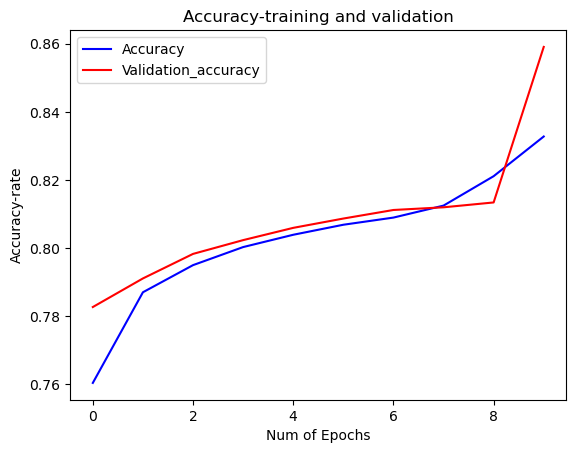

In [31]:
#accuracy-graphplot
plt.plot(baseline_autoencoder_result.history['accuracy'],'b')
plt.plot(baseline_autoencoder_result.history['val_accuracy'],'r')
#graph-title
plt.title('Accuracy-training and validation')
#graph-xaxisLabel
plt.xlabel('Num of Epochs')
#graph-yaxislabel
plt.ylabel('Accuracy-rate')
#graph-key/legend
plt.legend(['Accuracy', 'Validation_accuracy'])

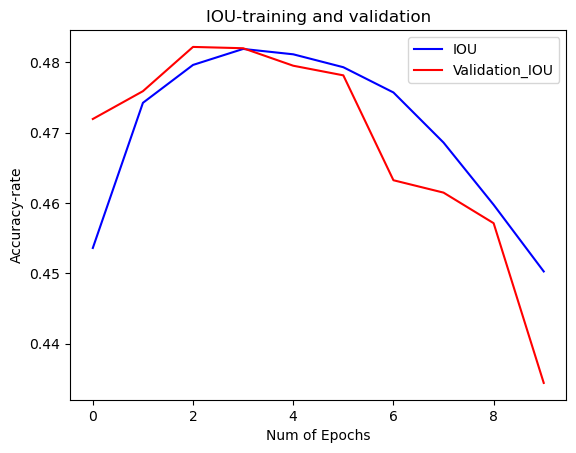

In [32]:
#iou-graphplot
plt.plot(baseline_autoencoder_result.history['one_hot_mean_io_u'],'b')
plt.plot(baseline_autoencoder_result.history['val_one_hot_mean_io_u'],'r')
#graph-title
plt.title('IOU-training and validation')
#graph-xaxisLabel
plt.xlabel('Num of Epochs')
#graph-yaxislabel
plt.ylabel('Accuracy-rate')
#graph-key/legend
plt.legend(['IOU', 'Validation_IOU'])

In [33]:
# Evaluate the model on the testing data
loss_testing, accur_testing, IOU_testing = baseline_autoencoder.evaluate(X_testVal, y_testVal)

# Print the testing results
print("Baseline model:Loss on testing data: ", loss_testing)
print("Baseline model:Accuracy on testing data: ", accur_testing)
print("Baseline model:IOU on testing data: ", IOU_testing)

32/32 [==============================] - 3s 88ms/step - loss: 0.3391 - accuracy: 0.8625 - one_hot_mean_io_u: 0.4340
Baseline model:Loss on testing data:  0.33910778164863586
Baseline model:Accuracy on testing data:  0.8625065088272095
Baseline model:IOU on testing data:  0.433974951505661


This model consists of basic layers of encoder and decoder model with 2 layers each. The accuracy and one-hot MeanIOU graphs and evalution results respresent the model as underfitting model.

###### Improved model-1

Based on the baseline model, the model will improved with more layers of encoder and decoder model.

In [34]:
input_shape = (224, 224, 3)  
num_classes = 2

#encoder-architecture
inputs = Input(shape=input_shape)
x_layer = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
x_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(x_layer)
x_layer = MaxPooling2D((2, 2), padding='same')(x_layer)
x_layer = Conv2D(128, (3, 3), activation='relu', padding='same')(x_layer)
x_layer = Conv2D(128, (3, 3), activation='relu', padding='same')(x_layer)
encoded = MaxPooling2D((2, 2), padding='same')(x_layer)

#decoder-architecture
x_layer = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x_layer = Conv2D(256, (3, 3), activation='relu', padding='same')(x_layer)
x_layer = UpSampling2D((2, 2))(x_layer)
x_layer = Conv2D(128, (3, 3), activation='relu', padding='same')(x_layer)
x_layer = Conv2D(128, (3, 3), activation='relu', padding='same')(x_layer)
x_layer = UpSampling2D((2, 2))(x_layer)
decoded = Conv2D(num_classes, (3, 3), padding='same')(x_layer)
output = Activation('softmax') (decoded)

#Initilaing the improved-autoencoder model
improved_autoencoder = Model(inputs, output)

#Compling model
improved_autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                             metrics=['accuracy', tf.keras.metrics.OneHotMeanIoU(num_classes=2)])

#summary of the model
improved_autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 128)     147584    
                                                           

In [35]:
#running the model through fit function
improved_autoencoder_result = improved_autoencoder.fit(X_trainVal, y_trainVal, 
                                                       validation_data=(X_validVal, y_validVal), 
                                                       epochs=10,batch_size=64)

Epoch 1/10
52/52 [==============================] - 920s 18s/step - loss: 0.8586 - accuracy: 0.7943 - one_hot_mean_io_u_1: 0.4828 - val_loss: 0.3468 - val_accuracy: 0.8250 - val_one_hot_mean_io_u_1: 0.4816
Epoch 2/10
52/52 [==============================] - 894s 17s/step - loss: 0.2938 - accuracy: 0.8523 - one_hot_mean_io_u_1: 0.4588 - val_loss: 0.2547 - val_accuracy: 0.8779 - val_one_hot_mean_io_u_1: 0.4497
Epoch 3/10
52/52 [==============================] - 709s 14s/step - loss: 0.2598 - accuracy: 0.8922 - one_hot_mean_io_u_1: 0.4316 - val_loss: 0.2710 - val_accuracy: 0.8599 - val_one_hot_mean_io_u_1: 0.4632
Epoch 4/10
52/52 [==============================] - 720s 14s/step - loss: 0.2158 - accuracy: 0.9077 - one_hot_mean_io_u_1: 0.4274 - val_loss: 0.1662 - val_accuracy: 0.9356 - val_one_hot_mean_io_u_1: 0.4098
Epoch 5/10
52/52 [==============================] - 695s 13s/step - loss: 0.1443 - accuracy: 0.9462 - one_hot_mean_io_u_1: 0.4119 - val_loss: 0.1287 - val_accuracy: 0.9525 - va

In [36]:
tabluate_result(improved_autoencoder_result)

,loss,accuracy,one_hot_mean_io_u_1,val_loss,val_accuracy,val_one_hot_mean_io_u_1
0,0.858554,0.794253,0.482786,0.346787,0.825047,0.481579
1,0.293829,0.852280,0.458781,0.254743,0.877942,0.449744
2,0.259786,0.892239,0.431568,0.270952,0.859869,0.463209
3,0.215807,0.907712,0.427408,0.166232,0.935583,0.409839
4,0.144311,0.946201,0.411870,0.128690,0.952538,0.416103
5,0.254692,0.931773,0.408984,0.473015,0.794813,0.478025
6,0.382025,0.833667,0.457251,0.271181,0.862555,0.463143
7,0.248855,0.887763,0.439810,0.237780,0.896183,0.424750
8,0.228852,0.899384,0.432988,0.178365,0.928136,0.422903
9,0.198911,0.919303,0.422203,0.169697,0.936835,0.412293


In [37]:
training_mean_results(improved_autoencoder_result)

,Value
loss,0.308562
accuracy,0.886458
one_hot_mean_io_u_1,0.437365
val_loss,0.249744
val_accuracy,0.886950
val_one_hot_mean_io_u_1,0.442159


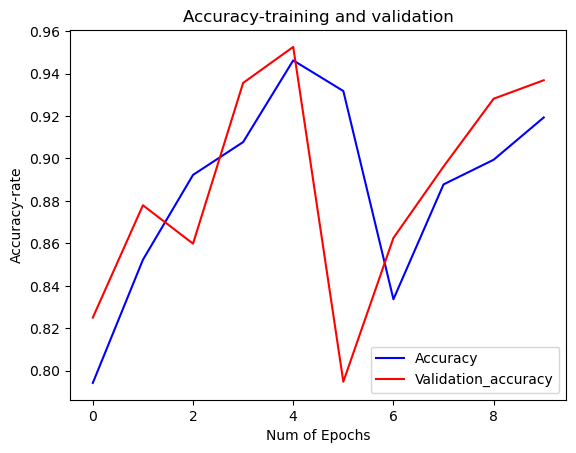

In [38]:
#accuracy-graphplot
plt.plot(improved_autoencoder_result.history['accuracy'],'b')
plt.plot(improved_autoencoder_result.history['val_accuracy'],'r')
#graph-title
plt.title('Accuracy-training and validation')
#graph-xaxisLabel
plt.xlabel('Num of Epochs')
#graph-yaxislabel
plt.ylabel('Accuracy-rate')
#graph-key/legend
plt.legend(['Accuracy', 'Validation_accuracy'])

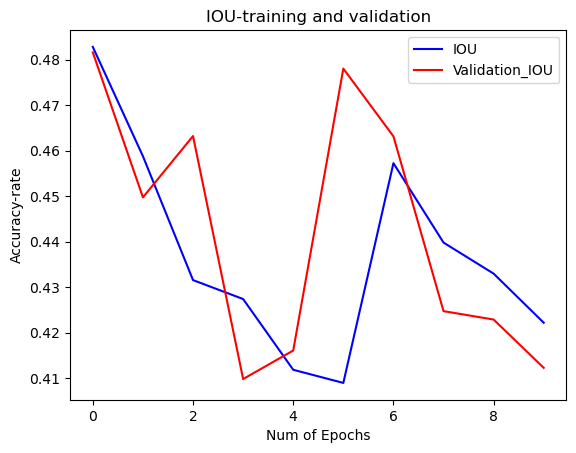

In [39]:
#iou-graphplot
plt.plot(improved_autoencoder_result.history['one_hot_mean_io_u_1'],'b')
plt.plot(improved_autoencoder_result.history['val_one_hot_mean_io_u_1'],'r')
#graph-title
plt.title('IOU-training and validation')
#graph-xaxisLabel
plt.xlabel('Num of Epochs')
#graph-yaxislabel
plt.ylabel('Accuracy-rate')
#graph-key/legend
plt.legend(['IOU', 'Validation_IOU'])

In [40]:
# Evaluate the model on the testing data
loss_testing, accur_testing, IOU_testing = improved_autoencoder.evaluate(X_testVal, y_testVal)

# Print the testing results
print("Overfit model:Loss on testing data: ", loss_testing)
print("Overfit model:Accuracy on testing data: ", accur_testing)
print("Overfit model:IOU on testing data: ", IOU_testing)

32/32 [==============================] - 54s 2s/step - loss: 0.1672 - accuracy: 0.9376 - one_hot_mean_io_u_1: 0.4122
Overfit model:Loss on testing data:  0.16716091334819794
Overfit model:Accuracy on testing data:  0.9376145601272583
Overfit model:IOU on testing data:  0.41223540902137756


This model consists of more layers of encoder and decoder model with 6 layers each. The accuracy and one-hot MeanIOU graphs and evalution results respresent the model as overfitting model.

###### Implementing a model with incorporation of Spatio-Temporal properties

Since spatio-temporal model generally invovles working with videos dataset and requires more compuational power and time, therfore according to this dataset, this model is based on the imporoved(overfitting) model implemented above where Convolutional3D will be used instead of Convolutional 2D, to incorporate the spatio -temporal to de detected by the model. 

In [41]:
input_shape = (224, 224, 3)
num_classes = 2

#encoder architecture
inputs = Input(shape=(input_shape[0], input_shape[1], input_shape[2], 1))
x_layer = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(inputs)
x_layer = BatchNormalization()(x_layer)
x_layer = Conv3D(16, (3, 3, 3), activation='relu', padding='same', strides=(2, 2, 1))(x_layer)
x_layer = BatchNormalization()(x_layer)
x_layer = Conv3D(32, (3, 3, 3), activation='relu', padding='same', strides=(2, 2, 1))(x_layer)
x_layer = BatchNormalization()(x_layer)
encoded = x_layer

#decoder architecture
x_layer = Conv3DTranspose(16, (3, 3, 3), activation='relu', padding='same', strides=(2, 2, 1))(encoded)
x_layer = BatchNormalization()(x_layer)
x_layer = Conv3DTranspose(8, (3, 3, 3), activation='relu', padding='same', strides=(2, 2, 1))(x_layer)
x_layer = BatchNormalization()(x_layer)
x_layer = Conv3DTranspose(1, (3, 3, 3), padding='same')(x_layer)
decoded = x_layer

#Initilaing the spatio-temporal-autoencoder model
spatioTemporal_autoencoder = tf.keras.models.Model(inputs, decoded)

# Compile the model
spatioTemporal_autoencoder.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

#summary of the model
spatioTemporal_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3, 1)   0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 224, 224, 3, 8)    224       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 3, 8)    32        
 Normalization)                                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 112, 112, 3, 16)   3472      
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 3, 16)   64        
 chNormalization)                                                
                                                           

The IOU callback function has been modified to take into consideration of temporal features used in the spatio-temporal model below.

In [42]:
#function class code is referenced from:
#https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

# Callback to compute IoU
class IoUCallback(keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val
    
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val)
        y_pred = np.argmax(y_pred, axis=-1)
        iou = self.calculate_iou(self.y_val, y_pred)
        logs['val_iou'] = iou
    
    def calculate_iou(self, y_true, y_pred):
        y_true = np.squeeze(y_true, axis=-1)  
        y_pred = np.argmax(y_pred, axis=-1)
        intersection = np.logical_and(y_true, y_pred)
        union = np.logical_or(y_true, y_pred)
        iou = np.sum(intersection) / np.sum(union)
        return iou
    
# Create the IoU callback
iou_callback = IoUCallback(X_validVal, y_validVal)

In [43]:
#running the model through fit function
spatioTemporal_autoencoder_result =spatioTemporal_autoencoder.fit(X_trainVal, y_trainVal,
                                                                  validation_data=(X_validVal, y_validVal),
                                                                  epochs=10, batch_size=64,
                                                                  callbacks=[iou_callback])

Epoch 1/10
52/52 [==============================] - 279s 5s/step - loss: 0.3009 - accuracy: 0.7659 - val_loss: 0.5365 - val_accuracy: 0.7446 - val_iou: 0.0000e+00
Epoch 2/10
52/52 [==============================] - 281s 5s/step - loss: 0.1152 - accuracy: 0.8441 - val_loss: 0.2194 - val_accuracy: 0.7886 - val_iou: 0.0000e+00
Epoch 3/10
52/52 [==============================] - 288s 6s/step - loss: 0.0965 - accuracy: 0.8739 - val_loss: 0.1987 - val_accuracy: 0.8014 - val_iou: 0.0000e+00
Epoch 4/10
52/52 [==============================] - 289s 6s/step - loss: 0.0874 - accuracy: 0.8830 - val_loss: 0.1582 - val_accuracy: 0.8037 - val_iou: 0.0000e+00
Epoch 5/10
52/52 [==============================] - 284s 5s/step - loss: 0.0775 - accuracy: 0.8990 - val_loss: 0.1512 - val_accuracy: 0.8036 - val_iou: 0.0000e+00
Epoch 6/10
52/52 [==============================] - 288s 6s/step - loss: 0.0689 - accuracy: 0.9120 - val_loss: 0.1315 - val_accuracy: 0.8078 - val_iou: 0.0000e+00
Epoch 7/10
52/52 [====

In [44]:
tabluate_result(spatioTemporal_autoencoder_result)

,loss,accuracy,val_loss,val_accuracy,val_iou
0,0.300915,0.765856,0.536521,0.744619,0.0
1,0.115246,0.844053,0.219370,0.788637,0.0
2,0.096492,0.873920,0.198743,0.801412,0.0
3,0.087412,0.882978,0.158208,0.803688,0.0
4,0.077549,0.899013,0.151214,0.803588,0.0
5,0.068891,0.911955,0.131493,0.807805,0.0
6,0.064851,0.917372,0.137370,0.798806,0.0
7,0.060098,0.923993,0.089809,0.868555,0.0
8,0.056687,0.928261,0.078530,0.891711,0.0
9,0.053807,0.932068,0.092521,0.880683,0.0


In [45]:
training_mean_results(spatioTemporal_autoencoder_result)

,Value
loss,0.098195
accuracy,0.887947
val_loss,0.179378
val_accuracy,0.818950
val_iou,0.000000


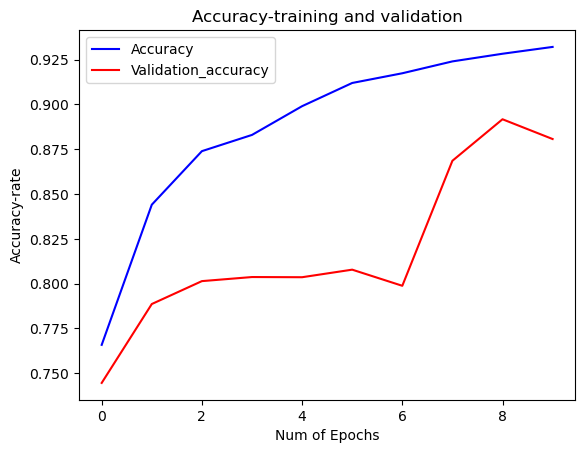

In [46]:
#accuracy-graphplot
plt.plot(spatioTemporal_autoencoder_result.history['accuracy'],'b')
plt.plot(spatioTemporal_autoencoder_result.history['val_accuracy'],'r')
#graph-title
plt.title('Accuracy-training and validation')
#graph-xaxisLabel
plt.xlabel('Num of Epochs')
#graph-yaxislabel
plt.ylabel('Accuracy-rate')
#graph-key/legend
plt.legend(['Accuracy', 'Validation_accuracy'])

In [47]:
# Evaluate the model on the validation data
loss_testing, accur_testing = spatioTemporal_autoencoder.evaluate(X_testVal, y_testVal)

# Print the evaluation results
print("Spatio_temporal model:Loss on testing data:", loss_testing)
print("Spatio_temporal model:Accuracy on testing data:", accur_testing)

32/32 [==============================] - 28s 871ms/step - loss: 0.0907 - accuracy: 0.8837
Spatio_temporal model:Loss on testing data: 0.09074317663908005
Spatio_temporal model:Accuracy on testing data: 0.8837196826934814


The results upon incoporating the spatio temporal features remain unstatisfactory and the IOU value is still 0, indicating that no accurate-overlap predictions were made.

##### Fine Tuned Model

This model is based on fine-tuning the improved model(Overfitting) the hyperparameters such as L1,L2 regulariser and Dropout.

In [48]:
input_shape = (224, 224, 3)
num_classes = 2

# encoder-architecture
inputs = Input(shape=input_shape)
x_layer = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
x_layer = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x_layer)
x_layer = MaxPooling2D((2, 2), padding='same')(x_layer)
x_layer = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x_layer)
x_layer = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x_layer)
x_layer = MaxPooling2D((2, 2), padding='same')(x_layer)

# Reduce Dropout rate
x_layer = Dropout(0.2)(x_layer)

encoded = x_layer

# decoder-architecture
x_layer = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(encoded)
x_layer = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x_layer)
x_layer = UpSampling2D((2, 2))(x_layer)
x_layer = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x_layer)
x_layer = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x_layer)
x_layer = UpSampling2D((2, 2))(x_layer)

# Reduce Dropout rate
x_layer = Dropout(0.2)(x_layer)

decoded = Conv2D(num_classes, (3, 3), padding='same')(x_layer)
output = Activation('softmax')(decoded)

# Initializing the improved-autoencoder model
regularised_autoencoder = Model(inputs, output)

# Compiling model
regularised_autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
                              metrics=['accuracy', tf.keras.metrics.OneHotMeanIoU(num_classes=2)])

# Summary of the model
regularised_autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 64)      36928     
                                                           

In [49]:
#running the model through fit function
regularised_autoencoder_result = regularised_autoencoder.fit(X_trainVal, y_trainVal, 
                                                       validation_data=(X_validVal, y_validVal), 
                                                       epochs=10,batch_size=64)

Epoch 1/10
52/52 [==============================] - 232s 4s/step - loss: 0.9909 - accuracy: 0.7923 - one_hot_mean_io_u_2: 0.4813 - val_loss: 0.6817 - val_accuracy: 0.8713 - val_one_hot_mean_io_u_2: 0.4443
Epoch 2/10
52/52 [==============================] - 245s 5s/step - loss: 0.6090 - accuracy: 0.8887 - one_hot_mean_io_u_2: 0.4262 - val_loss: 0.5506 - val_accuracy: 0.8976 - val_one_hot_mean_io_u_2: 0.4397
Epoch 3/10
52/52 [==============================] - 248s 5s/step - loss: 0.4971 - accuracy: 0.9235 - one_hot_mean_io_u_2: 0.4158 - val_loss: 0.4601 - val_accuracy: 0.9324 - val_one_hot_mean_io_u_2: 0.4142
Epoch 4/10
52/52 [==============================] - 248s 5s/step - loss: 0.4557 - accuracy: 0.9319 - one_hot_mean_io_u_2: 0.4135 - val_loss: 0.4334 - val_accuracy: 0.9416 - val_one_hot_mean_io_u_2: 0.4121
Epoch 5/10
52/52 [==============================] - 243s 5s/step - loss: 0.4027 - accuracy: 0.9471 - one_hot_mean_io_u_2: 0.4095 - val_loss: 0.3796 - val_accuracy: 0.9528 - val_one

In [50]:
tabluate_result(regularised_autoencoder_result)

,loss,accuracy,one_hot_mean_io_u_2,val_loss,val_accuracy,val_one_hot_mean_io_u_2
0,0.990939,0.792279,0.481280,0.681727,0.871310,0.444348
1,0.608996,0.888722,0.426164,0.550610,0.897635,0.439706
2,0.497059,0.923501,0.415803,0.460135,0.932414,0.414154
3,0.455725,0.931940,0.413455,0.433360,0.941596,0.412058
4,0.402685,0.947124,0.409544,0.379591,0.952765,0.392794
5,0.350500,0.961844,0.405193,0.324978,0.968549,0.401738
6,0.368681,0.948955,0.410400,0.416710,0.896990,0.369837
7,0.356618,0.949195,0.411043,0.299711,0.971976,0.403709
8,0.373829,0.937109,0.411009,0.332991,0.950498,0.392024
9,0.298452,0.965978,0.406848,0.272161,0.973524,0.400099


In [51]:
training_mean_results(regularised_autoencoder_result)

,Value
loss,0.470348
accuracy,0.924665
one_hot_mean_io_u_2,0.419074
val_loss,0.415197
val_accuracy,0.935726
val_one_hot_mean_io_u_2,0.407047


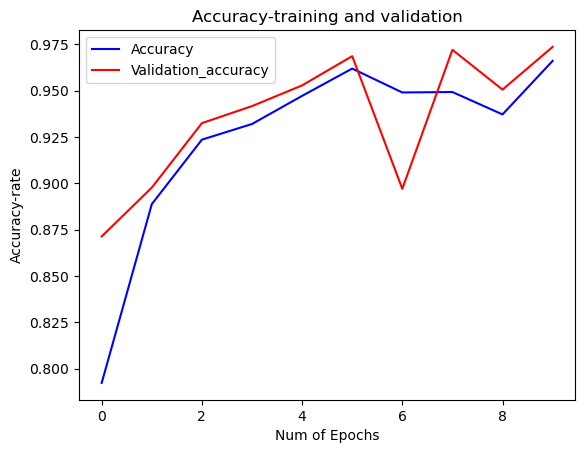

In [52]:
#accuracy-graphplot
plt.plot(regularised_autoencoder_result.history['accuracy'],'b')
plt.plot(regularised_autoencoder_result.history['val_accuracy'],'r')
#graph-title
plt.title('Accuracy-training and validation')
#graph-xaxisLabel
plt.xlabel('Num of Epochs')
#graph-yaxislabel
plt.ylabel('Accuracy-rate')
#graph-key/legend
plt.legend(['Accuracy', 'Validation_accuracy'])

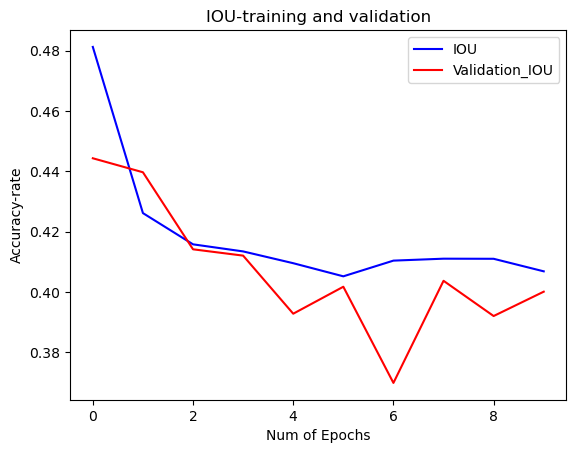

In [53]:
#iou-graphplot
plt.plot(regularised_autoencoder_result.history['one_hot_mean_io_u_2'],'b')
plt.plot(regularised_autoencoder_result.history['val_one_hot_mean_io_u_2'],'r')
#graph-title
plt.title('IOU-training and validation')
#graph-xaxisLabel
plt.xlabel('Num of Epochs')
#graph-yaxislabel
plt.ylabel('Accuracy-rate')
#graph-key/legend
plt.legend(['IOU', 'Validation_IOU'])

In [54]:
# Evaluate the model on the testing data
loss_testing, accur_testing, IOU_testing = regularised_autoencoder.evaluate(X_testVal, y_testVal)

# Print the testing results
print("Regularised model:Loss on testing data: ", loss_testing)
print("Regularised model:Accuracy on testing data: ", accur_testing)
print("Regularised model:IOU on testing data: ", IOU_testing)

32/32 [==============================] - 18s 557ms/step - loss: 0.2696 - accuracy: 0.9744 - one_hot_mean_io_u_2: 0.4006
Regularised model:Loss on testing data:  0.26963117718696594
Regularised model:Accuracy on testing data:  0.9744100570678711
Regularised model:IOU on testing data:  0.4006029963493347


### Final-deep convolutional auto-encoder model

This model based on the balanced performance from the models implemented above.

In [59]:
# Define the input shape
input_shape = (224, 224, 3)
num_classes = 1

# Define the encoder architecture
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Define the decoder architecture
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.2)(x)
decoded = Conv2D(num_classes, (3, 3), padding='same')(x)
output = Activation('sigmoid')(decoded)

# Create the autoencoder model
final_SemSegautoencoder = Model(inputs, output)

# Compile the model
final_SemSegautoencoder.compile(optimizer='adam', loss='binary_crossentropy', 
                    metrics=['accuracy', 
                             tf.keras.metrics.OneHotMeanIoU(num_classes=num_classes)])

# Print the summary of the model
final_SemSegautoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_47 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_29 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_48 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_30 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 112, 112, 32)      0   

In [60]:
#running the model through fit function
final_SemSegautoencoder_result = final_SemSegautoencoder.fit(X_trainVal, y_trainVal, 
                                                 validation_data=(X_validVal, y_validVal),
                                                 epochs=10,batch_size=64)

Epoch 1/10
52/52 [==============================] - 248s 5s/step - loss: 0.2489 - accuracy: 0.9120 - one_hot_mean_io_u_5: 1.0000 - val_loss: 0.6850 - val_accuracy: 0.8060 - val_one_hot_mean_io_u_5: 1.0000
Epoch 2/10
52/52 [==============================] - 241s 5s/step - loss: 0.0744 - accuracy: 0.9753 - one_hot_mean_io_u_5: 1.0000 - val_loss: 0.3658 - val_accuracy: 0.8788 - val_one_hot_mean_io_u_5: 1.0000
Epoch 3/10
52/52 [==============================] - 260s 5s/step - loss: 0.0542 - accuracy: 0.9829 - one_hot_mean_io_u_5: 1.0000 - val_loss: 0.2005 - val_accuracy: 0.9353 - val_one_hot_mean_io_u_5: 1.0000
Epoch 4/10
52/52 [==============================] - 245s 5s/step - loss: 0.0456 - accuracy: 0.9859 - one_hot_mean_io_u_5: 1.0000 - val_loss: 0.0759 - val_accuracy: 0.9743 - val_one_hot_mean_io_u_5: 1.0000
Epoch 5/10
52/52 [==============================] - 231s 4s/step - loss: 0.0417 - accuracy: 0.9873 - one_hot_mean_io_u_5: 1.0000 - val_loss: 0.0510 - val_accuracy: 0.9835 - val_one

In [61]:
tabluate_result(final_SemSegautoencoder_result)

,loss,accuracy,one_hot_mean_io_u_5,val_loss,val_accuracy,val_one_hot_mean_io_u_5
0,0.248866,0.912045,1.0,0.684961,0.806039,1.0
1,0.074442,0.975335,1.0,0.365756,0.878786,1.0
2,0.054244,0.982854,1.0,0.200524,0.935264,1.0
3,0.045636,0.985940,1.0,0.075873,0.974331,1.0
4,0.041674,0.987290,1.0,0.051008,0.983462,1.0
5,0.038258,0.988530,1.0,0.041098,0.987165,1.0
6,0.037047,0.988932,1.0,0.043744,0.986337,1.0
7,0.034891,0.989753,1.0,0.036335,0.989082,1.0
8,0.033372,0.990326,1.0,0.036000,0.989338,1.0
9,0.032747,0.990523,1.0,0.035316,0.989526,1.0


In [62]:
training_mean_results(final_SemSegautoencoder_result)

,Value
loss,0.064118
accuracy,0.979153
one_hot_mean_io_u_5,1.000000
val_loss,0.157062
val_accuracy,0.951933
val_one_hot_mean_io_u_5,1.000000


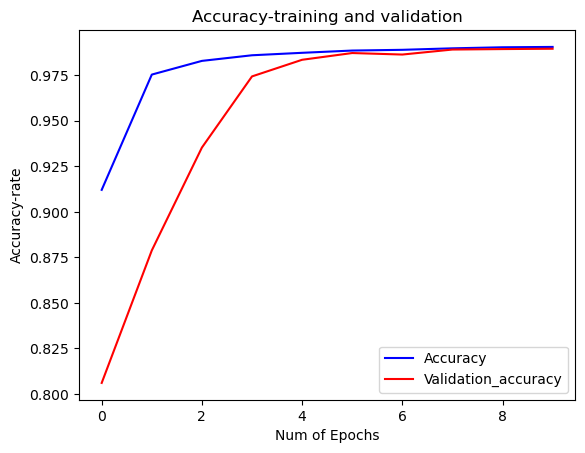

In [63]:
#accuracy-graphplot
plt.plot(final_SemSegautoencoder_result.history['accuracy'],'b')
plt.plot(final_SemSegautoencoder_result.history['val_accuracy'],'r')
#graph-title
plt.title('Accuracy-training and validation')
#graph-xaxisLabel
plt.xlabel('Num of Epochs')
#graph-yaxislabel
plt.ylabel('Accuracy-rate')
#graph-key/legend
plt.legend(['Accuracy', 'Validation_accuracy'])

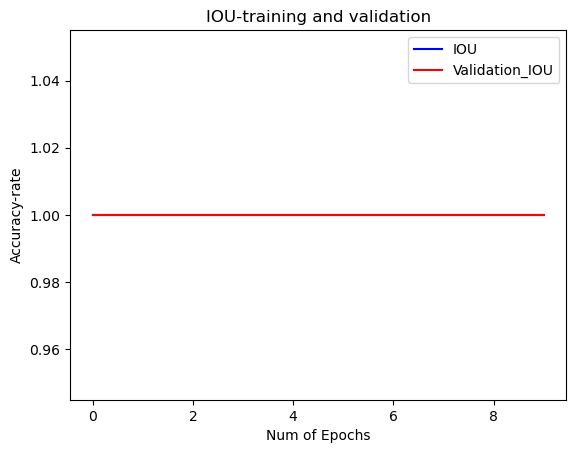

In [65]:
#iou-graphplot
plt.plot(final_SemSegautoencoder_result.history['one_hot_mean_io_u_5'],'b')
plt.plot(final_SemSegautoencoder_result.history['val_one_hot_mean_io_u_5'],'r')
#graph-title
plt.title('IOU-training and validation')
#graph-xaxisLabel
plt.xlabel('Num of Epochs')
#graph-yaxislabel
plt.ylabel('Accuracy-rate')
#graph-key/legend
plt.legend(['IOU', 'Validation_IOU'])

In [66]:
# Evaluate the model on the testing data
loss_testing, accur_testing, IOU_testing = final_SemSegautoencoder.evaluate(X_testVal, y_testVal)

# Print the testing results
print("Final Model:Loss on testing data: ", loss_testing)
print("Final Model:Accuracy on testing data: ", accur_testing)
print("Final Model:IOU on testing data: ", IOU_testing)

32/32 [==============================] - 15s 484ms/step - loss: 0.0343 - accuracy: 0.9898 - one_hot_mean_io_u_5: 1.0000
Final Model:Loss on testing data:  0.03433726355433464
Final Model:Accuracy on testing data:  0.9897887706756592
Final Model:IOU on testing data:  1.0


### EVALUATION

16/16 [==============================] - 16s 948ms/step


Text(0.5, 1.0, 'Semantic segmentation:Actual')

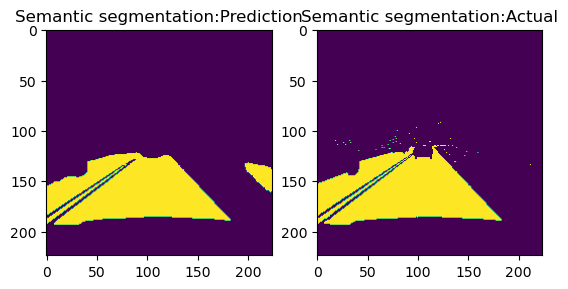

In [67]:
#prediction
X_test = X_testVal.astype(float)
y_predictVal = final_SemSegautoencoder.predict(X_test, batch_size=64)
predicted_value = y_predictVal[0].flatten()
predicted_value = np.array([1 if i >= 0.5 else 0 for i in predicted_value])

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(predicted_value.reshape(224,224))
ax[0].set_title('Semantic segmentation:Prediction')
ax[1].imshow(y_testVal[0].reshape(224,224))
ax[1].set_title('Semantic segmentation:Actual')

We will use numerous metrics to analyze the model in order to establish that our final model is correct.
1. Precision score
2. Recall score
3. F1 score
4. Confusion matrix

In [68]:
#initialising predicted values
y_predictVal=final_SemSegautoencoder.predict(X_testVal)

#reshaping values to values between -1 and 1
y_testVal=y_testVal.reshape(-1,1)
y_predictVal=y_predictVal.reshape(-1,1)

y_testVal=np.argmax(y_testVal,axis=1)
y_predictVal=np.argmax(y_predictVal,axis=1)

32/32 [==============================] - 15s 472ms/step


In [69]:
#calculating and obtaining values
precision_value=precision_score(y_testVal,y_predictVal,average='micro')
recall_value=recall_score(y_testVal,y_predictVal,average='micro')
f1_value=f1_score(y_testVal,y_predictVal,average='micro')

In [70]:
print("Precision value:",precision_value)
print("Recall value:",recall_value)
print("F1 score:",f1_value)

Precision value: 1.0
Recall value: 1.0
F1 score: 1.0


Text(33.22222222222222, 0.5, 'truth')

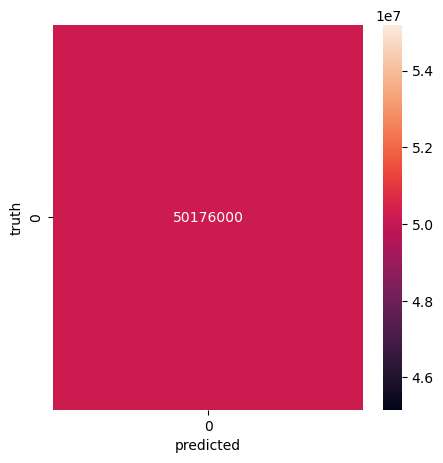

In [71]:
#confusion matrix
conf_Mat=confusion_matrix(y_testVal,y_predictVal)
import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(conf_Mat,annot=True,fmt='d')
plt.xlabel('predicted')
plt.ylabel('truth')

This signifies that all of the positive samples are classified correctly and that none of the positive samples are wrongly classified.